#### Notebook to read dataset provided by Knauer et al. 2022 and estimate $(\tau,\gamma)$

running the notebook in order will produce a modified data file in the folder "saved_data" if it doesn't already exist.

In [1]:
import numpy as np 
import pandas as pd 
import sys
sys.path.append('../../modules/')
import estimator as est # module for estimating parameters (Ci, gm*, \tau, \gamma)

df_raw = pd.read_csv('../raw_data/gm_dataset_Knauer_et_al_2022.csv', decimal=',', sep=';')

# Data is a meta-dataset assembled by Knauer et al. (2022)
# DOI: https://doi.org/10.1111/nph.18363

# UNITS:
# Assimilation rate:    µmol/m^2/s
# Stomatal conductance: mol/m^2/s
# Porosity:             --
# Mesophyll thickness:  µm
# Atmospheric CO2:      µmol/mol
# Compensation point:   µmol/mol

# print number of unique species and plant functional types
print('Number of data points:', len(df_raw))
print('Number of unique species:', df_raw['species'].nunique())
print('Number of unique plant functional types:', df_raw['plant_functional_type'].nunique())

Number of data points: 1883
Number of unique species: 617
Number of unique plant functional types: 13


In [2]:
# We require porosity and some measure of mesophyll thickness to be available
df = df_raw.dropna(subset=['fias_mesophyll'])
df = df.dropna(subset=['T_leaf', 'T_mesophyll'], how='all') # drop all where both are not available
print('Requrering porosity and mesophyll or leaf thickness: ')
print('Number of data points:', len(df))
print('Number of unique species:', df['species'].nunique())
print('Number of unique plant functional types:', df['plant_functional_type'].nunique())

#_____________________________________________________________________________________________________________________________________________________
# We add a colum for inference of mesophyll thickness
# We calculate the mean fraction T_mesophyll / T_leaf when both are available. 
# This yields ratio = 0.83 +- 0.11 with a pronounced peak
ratios = df['T_mesophyll'].to_numpy() / df['T_leaf'].to_numpy()
ratios = ratios[~np.isnan(ratios)] # remove those where either T_mesophyll or T_leaf was not available
# compute statistics
mean_ratio = np.mean(ratios)
std_ratio = np.std(ratios, ddof=1)
# print(f'Mean ratio T_mesophyll / T_leaf: {mean_ratio:.3f} ± {std_ratio:.3f}')

# If T_mesophyll is not directly available, we use the mean ratio to infer it from T_leaf
df.loc[:, 'mesophyll_thickness'] = np.nan
for i in df.index.tolist():
    if np.isnan(df.loc[i, 'T_mesophyll']):
        df.loc[i, 'mesophyll_thickness'] = mean_ratio * df.loc[i, 'T_leaf']
    else:
        df.loc[i, 'mesophyll_thickness'] = df.loc[i, 'T_mesophyll']

#_____________________________________________________________________________________________________________________________________________________
# We need values for gs_CO2, An, and Ci. We require An to be available and infer the others if missing
df = df.dropna(subset=['An'])
df = df.dropna(subset=['gs_CO2', 'Ca_gas_exchange', 'Ci'], how='all') # drop all where all three are not available

# empty columns for filling in
df.loc[:, 'stomatal_conductance'] = np.nan
df.loc[:, 'substomatal_conc'] = np.nan

# If gs_CO2 is not available, we infer it from An, Ca and Ci according to its definition: gs = An / (Ca - Ci)
for i in df.index.tolist():
    if np.isnan(df.loc[i, 'gs_CO2']):
        if not np.isnan(df.loc[i, 'An']) and not np.isnan(df.loc[i, 'Ca_gas_exchange']) and not np.isnan(df.loc[i, 'Ci']):
            df.loc[i, 'stomatal_conductance'] = df.loc[i, 'An'] / (df.loc[i, 'Ca_gas_exchange'] - df.loc[i, 'Ci'])
    else:
        df.loc[i, 'stomatal_conductance'] = df.loc[i, 'gs_CO2']
# drop all where stomatal conductance gs could not be inferred
df = df.dropna(subset=['stomatal_conductance'])

#_____________________________________________________________________________________________________________________________________________________
# If Ci is not available, we infer it from An, gs_CO2 and Ca
for i in df.index.tolist():
    if np.isnan(df.loc[i, 'Ci']):
        if not np.isnan(df.loc[i, 'An']) and not np.isnan(df.loc[i, 'stomatal_conductance']) and not np.isnan(df.loc[i, 'Ca_gas_exchange']):
            df.loc[i, 'substomatal_conc'] = df.loc[i, 'Ca_gas_exchange'] - df.loc[i, 'An'] / df.loc[i, 'stomatal_conductance']
    else:
        df.loc[i, 'substomatal_conc'] = df.loc[i, 'Ci']
# drop all where substomatal CO2 concentration Ci could not be inferred
df = df.dropna(subset=['substomatal_conc'])

#_____________________________________________________________________________________________________________________________________________________
# Lastly we need the CO2 compensation point C*. It is rarely quoted in the dataset, but very constant across samples: 39.9 ± 6.9 µmol/mol (n=50, species=27).
# We therefore substitute the mean value
mean_compensation = df_raw['Cistar'].mean()
std_compensation = df_raw['Cistar'].std(ddof=1)
df.loc[:, 'compensation_point'] = mean_compensation
# print(f'CO2 compensation point: {mean_compensation:.3f} ± {std_compensation:.3f}')

print("____________________________________________________")
print('Post processing to find (gs, An, Ci, C*): ')
print('Number of data points:', len(df))
print('Number of unique species:', df['species'].nunique())
print('Number of unique plant functional types:', df['plant_functional_type'].nunique())

# Finally, we save the processed data to a new CSV file
df.to_csv('../saved_data/Knauer2022_filtered.csv', index=False, decimal=',', sep=';')


Requrering porosity and mesophyll or leaf thickness: 
Number of data points: 218
Number of unique species: 113
Number of unique plant functional types: 9
____________________________________________________
Post processing to find (gs, An, Ci, C*): 
Number of data points: 174
Number of unique species: 88
Number of unique plant functional types: 8


 89%|████████▉ | 155/174 [05:38<00:29,  1.55s/it]

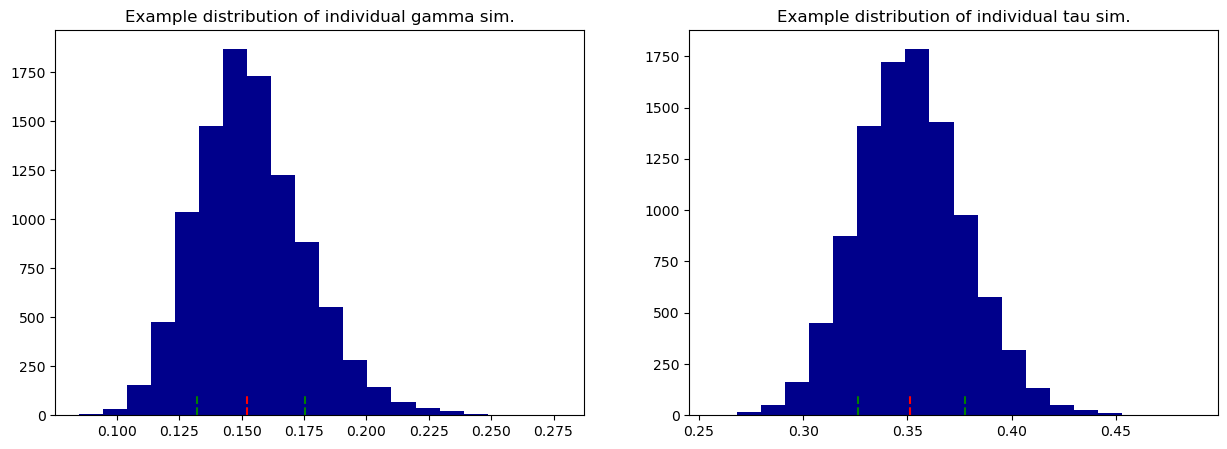

100%|██████████| 174/174 [06:15<00:00,  2.16s/it]


In [3]:
def estimate_conductances(df, rel_error=0.1):
    """ 
    Function to calculate modified mesophyll conductance (gm*) and intercellular airspace conductance (g_ias)
    df: data frame with columns 'fias_mesophyll', 'mesophyll_thickness', 'An', 'substomatal_conc', 'compensation_point'
    rel_error: option to add a relative error for later simulated error propagation (default is 10%). No errors are provided in the dataset by Knauer et al. 2022
    """
    # we calculate conductances g_ias (Niinemets & Reichstein, 2003) and gm* = An / (Ci - C*)
    diffusivity_in_air = 1.51e-5 # m2/s     CO2 diffusion constant in air at 25 *C (https://pmc.ncbi.nlm.nih.gov/articles/PMC4885940/)
    tortuosity = 1.57 # adopted from Tosens et al. 2012, Syvertsen et al. 1995. Bounded below by 1.0 and often in the range 1.4-1.6 (Borsuk et al. 2022)
    g_ias = (diffusivity_in_air * df["fias_mesophyll"]) / (1e-6 * df["mesophyll_thickness"] * 0.5 * tortuosity) # m/s
    # where we have translated cm2/s to m2/s and um to m
    df.loc[:, 'ias_conductance'] = g_ias / 0.02241  # convert from m/s to mol/m2/s to match An in units of umol/m2/s. The fraction reflects the molar conc. of air

    gm_star = df['An'] / (df['substomatal_conc'] - df['compensation_point'])  # mol/m2/s
    df.loc[:, 'mesophyll_conductance*'] = gm_star

    # Add relative errors to the conductances for simulated error probagation. Mean estimates are not affected
    df.loc[:, 'd_mesophyll_conductance*'] = rel_error * df['mesophyll_conductance*'] # 10% error
    df.loc[:, 'd_stomatal_conductance'] = rel_error * df['stomatal_conductance'] # 10% error
    df.loc[:, 'd_ias_conductance'] = rel_error * df['ias_conductance'] # 10% error
    return df


# Treat all as hypostomatous
df_hypo = pd.read_csv('../saved_data/Knauer2022_filtered.csv', decimal=',', sep=';')
df_hypo = estimate_conductances(df_hypo, rel_error=0.1)
df_hypo, (taus_hypo, dtaus_hypo), (gammas_hypo, dgammas_hypo) = est.estimate_principle_parameters(df_hypo, plot_sample=False)
df_hypo.to_csv('../saved_data/Knauer2022_hypostomatous.csv', index=False, decimal=',', sep=';')
